# Plot Results Analysis

This notebook analyzes the results of the Simulation. It loads CSV data for potential, electric field, and permittivity, and generates several plots.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import glob
import sys
import matplotlib.colors as mcolors

%matplotlib inline

## Helper Functions

In [2]:
def load_1d_csv(filename):
    if not os.path.exists(filename):
        print(f"Error: File {filename} not found.")
        return None
    return np.loadtxt(filename, delimiter=',')

def load_2d_csv(filename):
    if not os.path.exists(filename):
        print(f"Error: File {filename} not found.")
        return None
    data = np.loadtxt(filename, delimiter=',')
    return data

def load_geometry_params_for_plot(filepath):
    """Loads specific geometry parameters from a CSV file for plotting purposes."""
    params = {}
    if not os.path.exists(filepath):
        print(f"Error: Geometry parameters file {filepath} not found.")
        return None
    try:
        with open(filepath, mode='r') as infile:
            reader = csv.reader(infile)
            for rows in reader:
                if len(rows) == 2:
                    key = rows[0]
                    value = rows[1]
                    try:
                        params[key] = float(value)
                    except ValueError:
                        # Silently handle non-numeric values (e.g. geometry_type)
                        params[key] = value # Store as string
    except Exception as e:
        print(f"Error reading geometry parameters file {filepath}: {e}")
        return None
    return params

## Configuration and Data Loading

In [3]:
# Select the geometry version using a number
# 1: geometria_Denti_sfasati_profondi
# 2: geometria_Denti_uguali
# 3: geometria_piana_rastremata
# 4: piana
# 5: Default fallback (first available)

geometry_version = 1


folder_map = {
    1: "geometria_Denti_sfasati_profondi_proton",
    2: "geometria_Denti_uguali_proton",
    3: "geometria_piana_rastremata_proton",
    4: "piana_proton"
}

output_folder_name = folder_map.get(geometry_version, "")

if not os.path.isdir(output_folder_name):
    print(f"Error: The specified folder '{output_folder_name}' does not exist or version {geometry_version} is invalid.")
    likely_folders = [f for f in os.listdir('.') if os.path.isdir(f) and f.startswith("geometria")]
    if likely_folders:
        print(f"Available folders: {likely_folders}")
        output_folder_name = likely_folders[0]
        print(f"Falling back to: {output_folder_name}")
    else:
        print("Please ensure the C++ simulation has run and created the output folder.")
else:
    print(f"Using geometry version {geometry_version}: {output_folder_name}")

potential_file = os.path.join(output_folder_name, "potential.csv")
ex_file = os.path.join(output_folder_name, "electric_field_x.csv")
ey_file = os.path.join(output_folder_name, "electric_field_y.csv")
eps_r_file = os.path.join(output_folder_name, "permittivity.csv")
x_coords_file = os.path.join(output_folder_name, "x_coordinates.csv")
y_coords_file = os.path.join(output_folder_name, "y_coordinates.csv")
geometry_params_file = os.path.join(output_folder_name, "geometry_params.csv")

# Load data
V = load_2d_csv(potential_file)
Ex = load_2d_csv(ex_file)
Ey = load_2d_csv(ey_file)
eps_r = load_2d_csv(eps_r_file)
x_coords = load_1d_csv(x_coords_file)
y_coords = load_1d_csv(y_coords_file)
geo_params = load_geometry_params_for_plot(geometry_params_file)

if V is None or Ex is None or Ey is None or eps_r is None or x_coords is None or y_coords is None:
    print("One or more data files could not be loaded.")
else:
    print("Data loaded successfully.")

Using geometry version 1: geometria_Denti_sfasati_profondi_proton
Data loaded successfully.


## Data Preparation

In [4]:
def draw_detailed_outlines(ax, x_coords_mesh, y_coords_mesh, eps_r_data_mesh, threshold, color_style):
    """Draws geometry outlines based on the permittivity map."""
    if threshold is None: # If no valid threshold, do not attempt to draw outlines
        # print("Skipping outlines as threshold is None.")
        return

    # Separate color and linestyle
    # Assuming color_style is like 'w--' or 'k--'
    color = color_style[0]
    linestyle = color_style[1:] if len(color_style) > 1 else '-' # Default to solid if no style part

    ax.contour(x_coords_mesh, y_coords_mesh, eps_r_data_mesh, levels=[threshold], colors=color, linestyles=linestyle, linewidths=0.8)

y_center_gap_idx = None
y_center_gap_abs = None 

if geo_params:
    y_si_base_h = geo_params.get("y_si_base_height")
    y_teeth_h_val = geo_params.get("initial_y_teeth_height") or geo_params.get("y_teeth_height") or geo_params.get("y_tooth_height") 
    y_vac_gap_thick_toothed = geo_params.get("y_vacuum_gap_thick")
    pad_bottom = geo_params.get("y_vacuum_padding_bottom", 0.0)

    if y_si_base_h is not None and y_teeth_h_val is not None and y_vac_gap_thick_toothed is not None:
        y_center_gap_abs = pad_bottom + y_si_base_h + y_teeth_h_val + (y_vac_gap_thick_toothed / 2.0)
        print(f"Using toothed geometry logic for profile plot y-center.")
    else:
        y_si_thick_start = geo_params.get("y_si_layer_thick_start")
        y_si_thick_end = geo_params.get("y_si_layer_thick_end")
        y_si_thick_right = geo_params.get("y_si_layer_thick_right")
        y_si_thick_left = geo_params.get("y_si_layer_thick_left")
        y_vacuum_gap_thick_var = geo_params.get("y_vacuum_gap_thick")
        
        if y_si_thick_start is not None and y_si_thick_end is not None and y_vacuum_gap_thick_var is not None:
            y_center_gap_abs = pad_bottom + y_si_thick_start + (y_vacuum_gap_thick_var / 2.0)
        elif y_si_thick_right is not None and y_si_thick_left is not None and y_vacuum_gap_thick_var is not None:
            y_center_gap_abs = pad_bottom + y_si_thick_left + (y_vacuum_gap_thick_var / 2.0)
        else:
             y_si_layer_thick_piana = geo_params.get("y_si_layer_thick_start") if geo_params.get("y_si_layer_thick_start") else geo_params.get("y_si_layer_thick")
             y_vacuum_gap_thick_piana = geo_params.get("y_vacuum_gap_thick")
             if y_si_layer_thick_piana is not None and y_vacuum_gap_thick_piana is not None:
                y_center_gap_abs = pad_bottom + y_si_layer_thick_piana + (y_vacuum_gap_thick_piana / 2.0)

    if y_center_gap_abs is not None:
        if y_coords is not None and len(y_coords) > 0:
            y_center_gap_idx = (np.abs(y_coords - y_center_gap_abs)).argmin()
            print(f"Calculated y-center for profile plot: {y_center_gap_abs:.2f} μm (index: {y_center_gap_idx})")
else:
    print("Warning: Geometry parameters not loaded. Profile plot might be skipped.")

E_mag = np.sqrt(Ex**2 + Ey**2)
X_mesh, Y_mesh = np.meshgrid(x_coords, y_coords)

outline_threshold_silicon = None
outline_threshold_aluminum = None

if eps_r is not None:
    unique_eps_values = np.unique(eps_r)
    unique_eps_values.sort() 
    
    if len(unique_eps_values) >= 3:
        val_vacuum = unique_eps_values[0]
        val_silicon = unique_eps_values[1]
        val_aluminum = unique_eps_values[-1]
        outline_threshold_silicon = (val_vacuum + val_silicon) / 2.0
        outline_threshold_aluminum = (val_silicon + val_aluminum) / 2.0
    elif len(unique_eps_values) >= 2:
        val_low = unique_eps_values[0]
        val_high = unique_eps_values[-1]
        if val_high > val_low + 0.5:
            outline_threshold_silicon = (val_low + val_high) / 2.0

Using toothed geometry logic for profile plot y-center.
Calculated y-center for profile plot: 70.00 μm (index: 140)


### Plot 1: Electric Potential

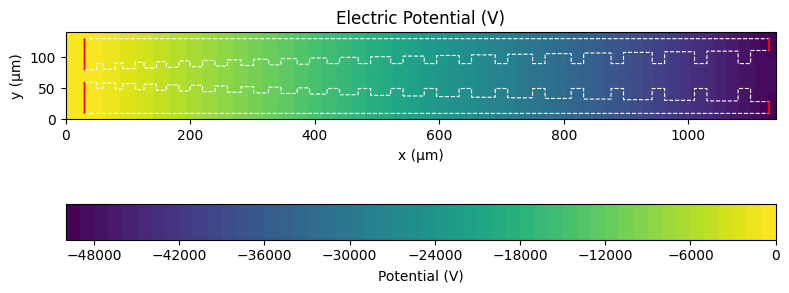

In [5]:
plt.figure(figsize=(8, 6))
ax_V = plt.gca()
contour_V = ax_V.contourf(X_mesh, Y_mesh, V, levels=50, cmap='viridis')
plt.colorbar(contour_V, ax=ax_V, label='Potential (V)', orientation='horizontal')
ax_V.set_title('Electric Potential (V)')
ax_V.set_xlabel('x (μm)')
ax_V.set_ylabel('y (μm)')
ax_V.set_aspect('equal', adjustable='box')
draw_detailed_outlines(ax_V, X_mesh, Y_mesh, eps_r, outline_threshold_silicon, 'w--')
draw_detailed_outlines(ax_V, X_mesh, Y_mesh, eps_r, outline_threshold_aluminum, 'r-')
plt.tight_layout()
plt.show()

### Plot 2: Electric Field Magnitude

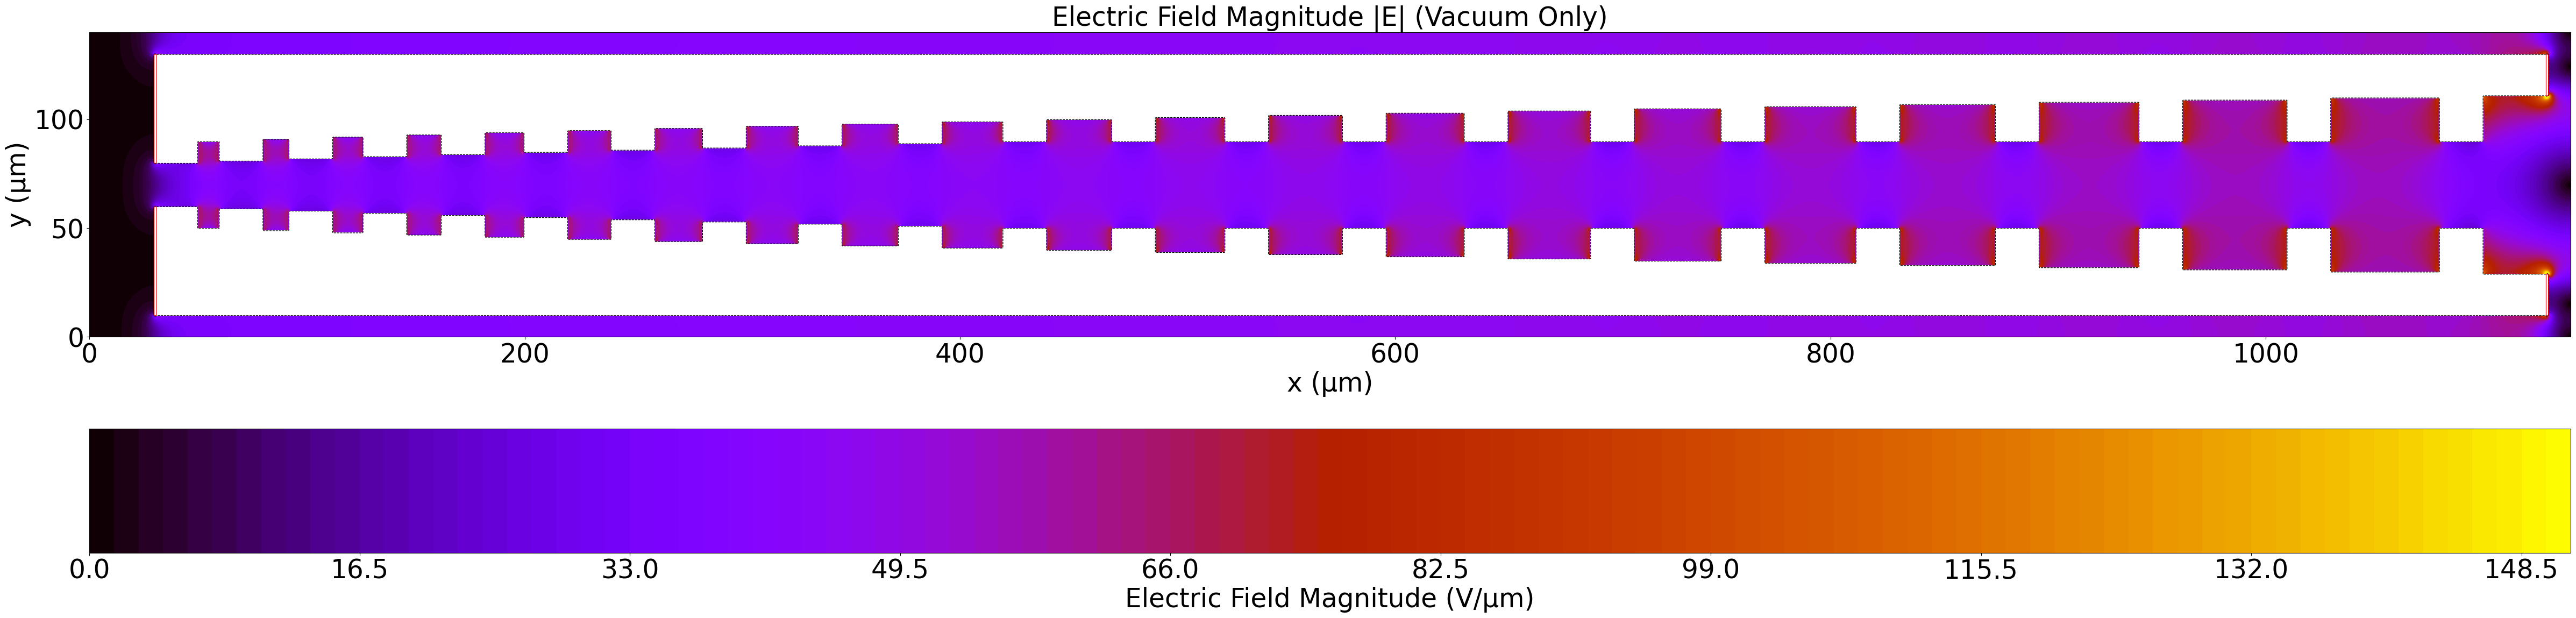

In [6]:
plt.figure(figsize=(48,43))
ax_Emag = plt.gca()

E_mag_vacuum = E_mag.copy()
if outline_threshold_silicon is not None:
    mask_not_vacuum = (eps_r >= outline_threshold_silicon)
    E_mag_vacuum[mask_not_vacuum] = np.nan 

contour_Emag = ax_Emag.contourf(X_mesh, Y_mesh, E_mag_vacuum, levels=150, cmap='gnuplot')
cbar=plt.colorbar(contour_Emag, ax=ax_Emag, orientation='horizontal', pad=0.04)
cbar.set_label('Electric Field Magnitude (V/μm)', fontsize=35)
cbar.ax.tick_params(axis='both',which='major', labelsize=35)
ax_Emag.set_title('Electric Field Magnitude |E| (Vacuum Only)', fontsize=35)
ax_Emag.set_xlabel('x (μm)', fontsize=35)
ax_Emag.set_ylabel('y (μm)', fontsize=35)
ax_Emag.set_aspect('equal', adjustable='box')
ax_Emag.tick_params(axis='both',which='major', labelsize=35)
draw_detailed_outlines(ax_Emag, X_mesh, Y_mesh, eps_r, outline_threshold_silicon, 'k--')
draw_detailed_outlines(ax_Emag, X_mesh, Y_mesh, eps_r, outline_threshold_aluminum, 'r-')

plt.tight_layout()
plt.show()

### Plot 3: Permittivity Map

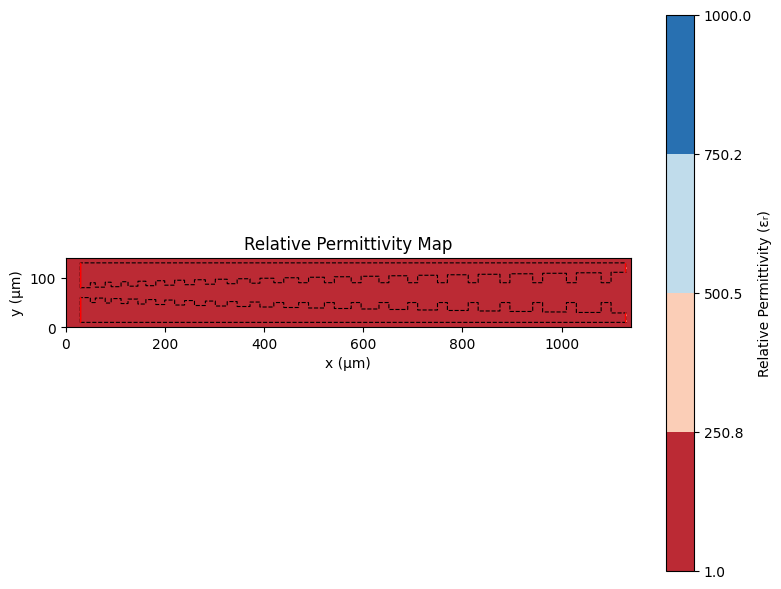

In [7]:
plt.figure(figsize=(8, 6))
ax_eps = plt.gca()

eps_min = np.min(eps_r)
eps_max = np.max(eps_r)

if eps_max > eps_min + 1e-6:
    contour_eps = ax_eps.contourf(X_mesh, Y_mesh, eps_r, levels=np.linspace(eps_min, eps_max, 5), cmap='RdBu')
    plt.colorbar(contour_eps, ax=ax_eps, label='Relative Permittivity (εᵣ)')
else:
    im_eps = ax_eps.imshow(eps_r, extent=[X_mesh.min(), X_mesh.max(), Y_mesh.min(), Y_mesh.max()], 
                           origin='lower', cmap='RdBu', aspect='auto')
    plt.colorbar(im_eps, ax=ax_eps, label='Relative Permittivity (εᵣ)')
    ax_eps.text(0.5, 0.95, f'Uniform εᵣ = {eps_min:.2f}', 
               transform=ax_eps.transAxes, ha='center', va='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax_eps.set_title('Relative Permittivity Map')
ax_eps.set_xlabel('x (μm)')
ax_eps.set_ylabel('y (μm)')
ax_eps.set_aspect('equal', adjustable='box')
draw_detailed_outlines(ax_eps, X_mesh, Y_mesh, eps_r, outline_threshold_silicon, 'k--')
draw_detailed_outlines(ax_eps, X_mesh, Y_mesh, eps_r, outline_threshold_aluminum, 'r-')
plt.tight_layout()
plt.show()

### Plot 4: Electric Field Quiver

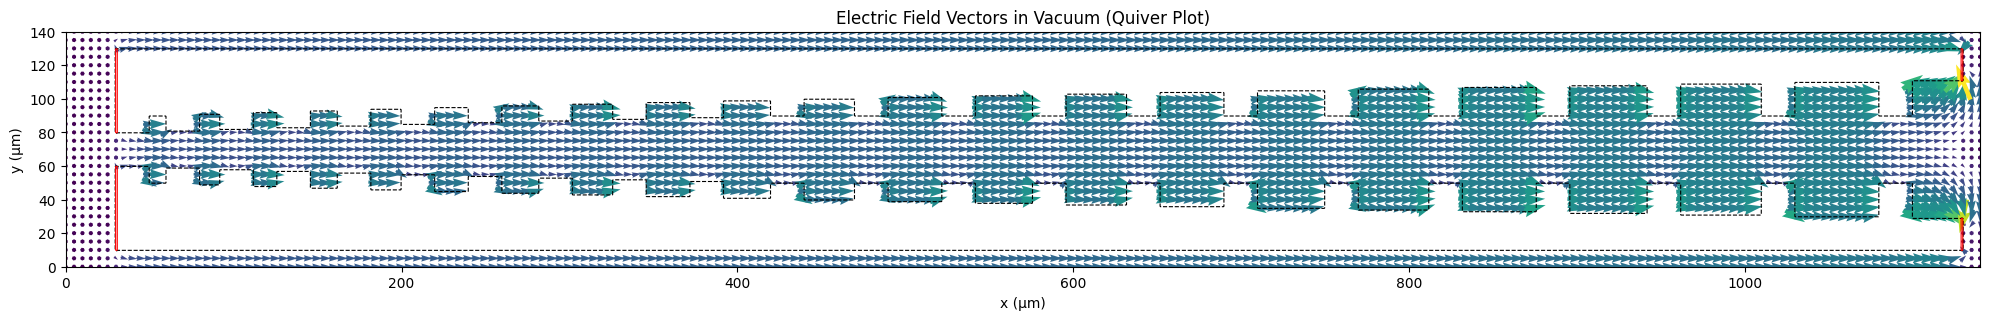

In [8]:
plt.figure(figsize=(20, 14))
ax_Evec = plt.gca()

skip_rate = 10
if y_coords.shape[0] // skip_rate < 2 :
    skip_rate_y = max(1, y_coords.shape[0] // 2 if y_coords.shape[0] > 1 else 1)
else:
    skip_rate_y = skip_rate
if x_coords.shape[0] // skip_rate < 2 :
    skip_rate_x = max(1, x_coords.shape[0] // 2 if x_coords.shape[0] > 1 else 1)
else:
    skip_rate_x = skip_rate

skip = (slice(None, None, skip_rate_y), slice(None, None, skip_rate_x))

Ex_quiver = Ex.copy()
Ey_quiver = Ey.copy()
Emag_quiver = E_mag.copy()

if outline_threshold_silicon is not None:
    mask_not_vacuum = (eps_r >= outline_threshold_silicon)
else:
    mask_not_vacuum = np.zeros_like(eps_r, dtype=bool)

Ex_quiver[mask_not_vacuum] = np.nan
Ey_quiver[mask_not_vacuum] = np.nan
Emag_quiver[mask_not_vacuum] = np.nan

if not np.all(np.isnan(Ex_quiver[skip])):
    ax_Evec.quiver(X_mesh[skip], Y_mesh[skip], 
                   Ex_quiver[skip], Ey_quiver[skip], Emag_quiver[skip], 
                   cmap='viridis', scale=6, scale_units='xy', angles='xy', 
                   headwidth=3, headlength=5, pivot='middle')

ax_Evec.set_title('Electric Field Vectors in Vacuum (Quiver Plot)')
ax_Evec.set_xlabel('x (μm)')
ax_Evec.set_ylabel('y (μm)')
ax_Evec.set_aspect('equal', adjustable='box')
#ax_Evec.set_xlim(15,60)
#ax_Evec.set_ylim(70,150)
draw_detailed_outlines(ax_Evec, X_mesh, Y_mesh, eps_r, outline_threshold_silicon, 'k--')
draw_detailed_outlines(ax_Evec, X_mesh, Y_mesh, eps_r, outline_threshold_aluminum, 'r-')
plt.tight_layout()
plt.show()

### Plot 5: Profile Plot (Center of Gap)

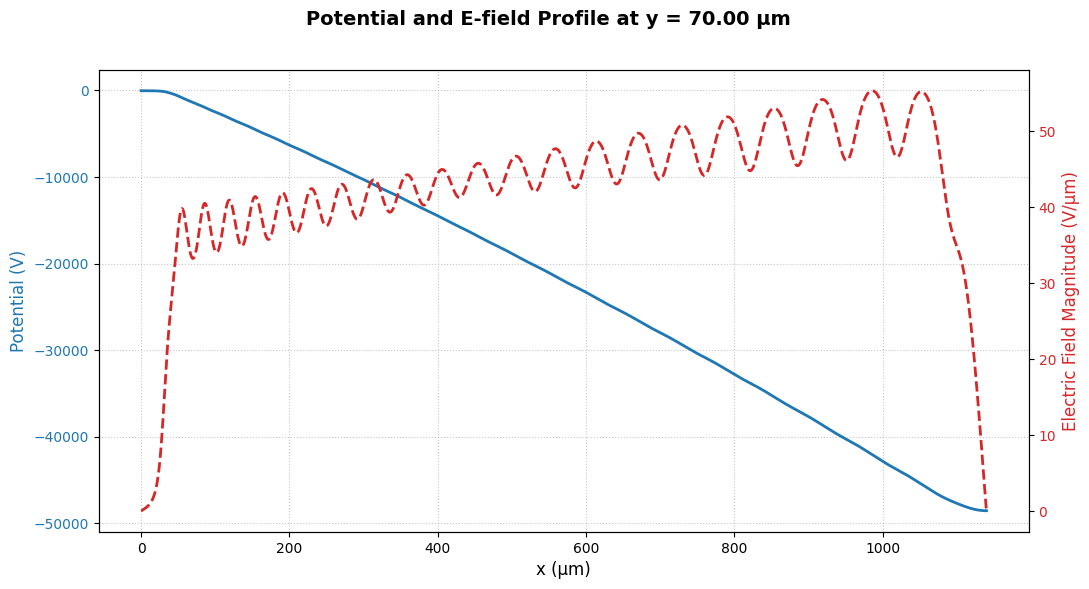

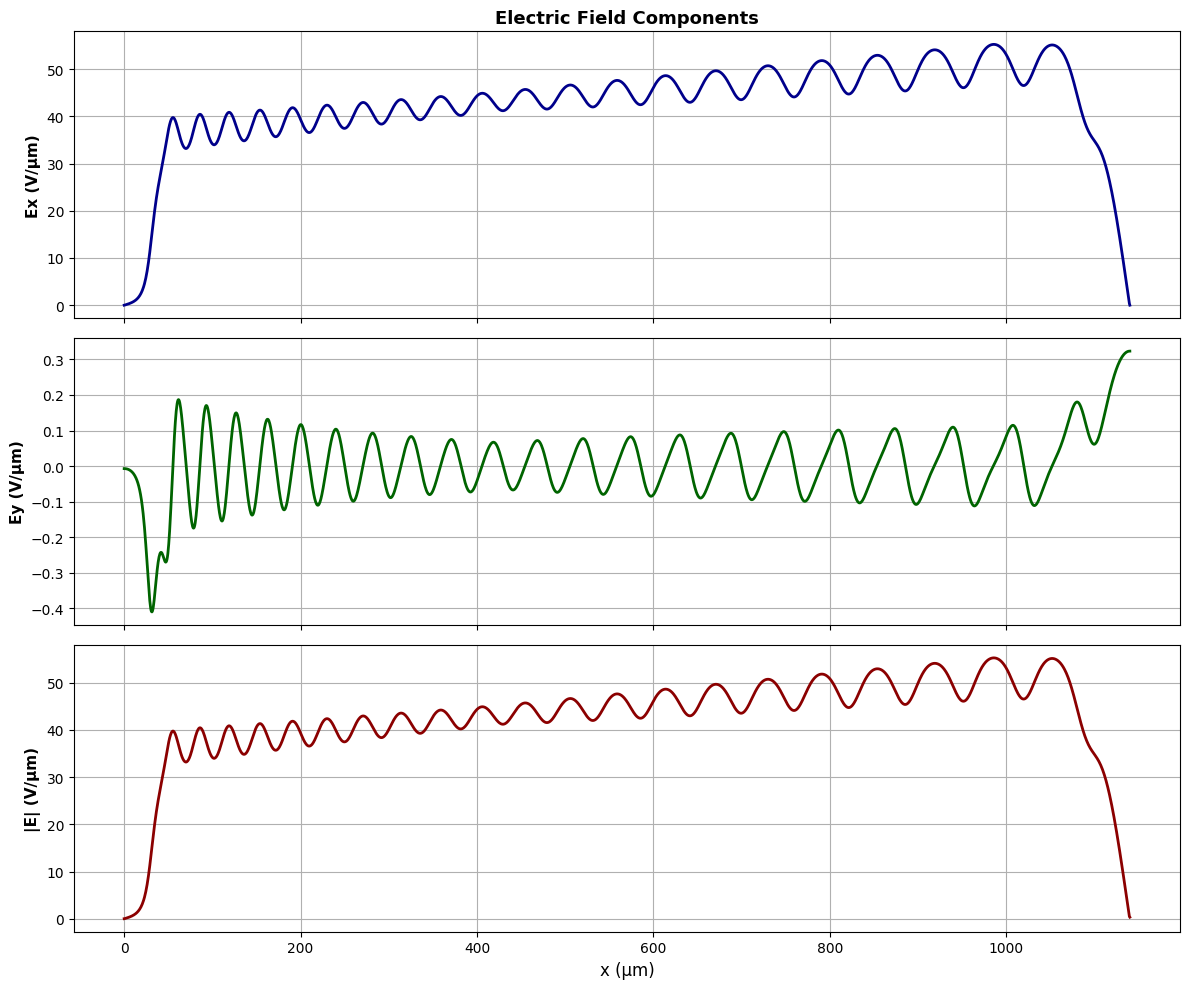

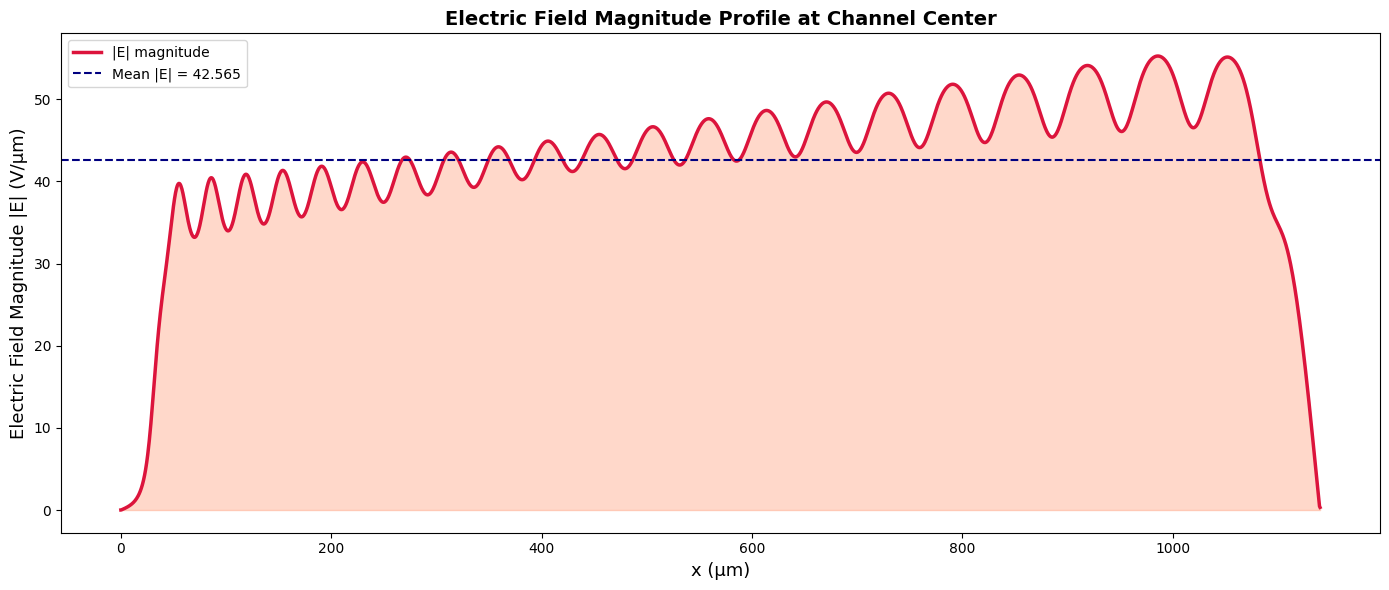

In [9]:
if y_center_gap_idx is not None:
    V_profile = V[y_center_gap_idx, :]
    Ex_profile = Ex[y_center_gap_idx, :]
    Ey_profile = Ey[y_center_gap_idx, :]
    Emag_profile = E_mag[y_center_gap_idx, :]

    # 5a: Combined Potential and E-field
    fig_profile, ax_profile_V = plt.subplots(figsize=(12, 6))

    color_V = 'tab:blue'
    ax_profile_V.set_xlabel('x (μm)', fontsize=12)
    ax_profile_V.set_ylabel('Potential (V)', color=color_V, fontsize=12)
    ax_profile_V.plot(x_coords, V_profile, color=color_V, linestyle='-', linewidth=2, label='Potential (V)')
    ax_profile_V.tick_params(axis='y', labelcolor=color_V)
    ax_profile_V.grid(True, linestyle=':', alpha=0.7)

    ax_profile_Emag = ax_profile_V.twinx() 
    color_Emag = 'tab:red'
    ax_profile_Emag.set_ylabel('Electric Field Magnitude (V/μm)', color=color_Emag, fontsize=12)
    ax_profile_Emag.plot(x_coords, Emag_profile, color=color_Emag, linestyle='--', linewidth=2, label='|E| (V/μm)')
    ax_profile_Emag.tick_params(axis='y', labelcolor=color_Emag)

    fig_profile.suptitle(f'Potential and E-field Profile at y = {y_coords[y_center_gap_idx]:.2f} μm', fontsize=14, fontweight='bold')
    plt.show()

    # 5b: Dedicated E-field components
    fig_efield, (ax_ex, ax_ey, ax_emag) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    
    ax_ex.plot(x_coords, Ex_profile, color='darkblue', linestyle='-', linewidth=2)
    ax_ex.set_ylabel('Ex (V/μm)', fontsize=11, fontweight='bold')
    ax_ex.set_title('Electric Field Components', fontsize=13, fontweight='bold')
    ax_ex.grid(True)
    
    ax_ey.plot(x_coords, Ey_profile, color='darkgreen', linestyle='-', linewidth=2)
    ax_ey.set_ylabel('Ey (V/μm)', fontsize=11, fontweight='bold')
    ax_ey.grid(True)
    
    ax_emag.plot(x_coords, Emag_profile, color='darkred', linestyle='-', linewidth=2)
    ax_emag.set_ylabel('|E| (V/μm)', fontsize=11, fontweight='bold')
    ax_emag.set_xlabel('x (μm)', fontsize=12)
    ax_emag.grid(True)
    
    plt.tight_layout()
    plt.show()

    # 5c: E-field magnitude detail
    fig_emag_detail, ax_emag_detail = plt.subplots(figsize=(14, 6))
    
    ax_emag_detail.plot(x_coords, Emag_profile, color='crimson', linestyle='-', linewidth=2.5, label='|E| magnitude')
    ax_emag_detail.fill_between(x_coords, 0, Emag_profile, alpha=0.3, color='coral')
    
    emag_mean = np.mean(Emag_profile)
    ax_emag_detail.axhline(y=emag_mean, color='navy', linestyle='--', linewidth=1.5, label=f'Mean |E| = {emag_mean:.3f}')
    
    ax_emag_detail.set_xlabel('x (μm)', fontsize=13)
    ax_emag_detail.set_ylabel('Electric Field Magnitude |E| (V/μm)', fontsize=13)
    ax_emag_detail.set_title(f'Electric Field Magnitude Profile at Channel Center', fontsize=14, fontweight='bold')
    ax_emag_detail.legend(loc='best')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping profile plots because y_center_gap_idx could not be determined.")

## Proton Trajectory Analysis

In [10]:
import pandas as pd

# Physical constants
M_Alpha_KG = 6.64465723e-27  # Mass of alpha in kg
E_CHARGE_C = 1.60217663e-19   # Elementary charge in Coulombs

all_trajectories_file = os.path.join(output_folder_name, "all_proton_trajectories.csv")
print(f"Loading trajectories from: {all_trajectories_file}")

df_all_trajectories = None
if os.path.exists(all_trajectories_file):
    try:
        required_columns = ['proton_id', 'time_s', 'x_m', 'y_m', 'vx_m_per_s', 'vy_m_per_s']
        df_all_trajectories = pd.read_csv(all_trajectories_file, usecols=required_columns)
        print(f"Loaded {len(df_all_trajectories)} trajectory points.")
    except Exception as e:
        print(f"Error reading trajectory file: {e}")
else:
    print("Trajectory file not found.")

Loading trajectories from: geometria_Denti_sfasati_profondi_proton\all_proton_trajectories.csv
Loaded 38772678 trajectory points.


### Plot 6: Proton Trajectories

Plotting 100 trajectories...


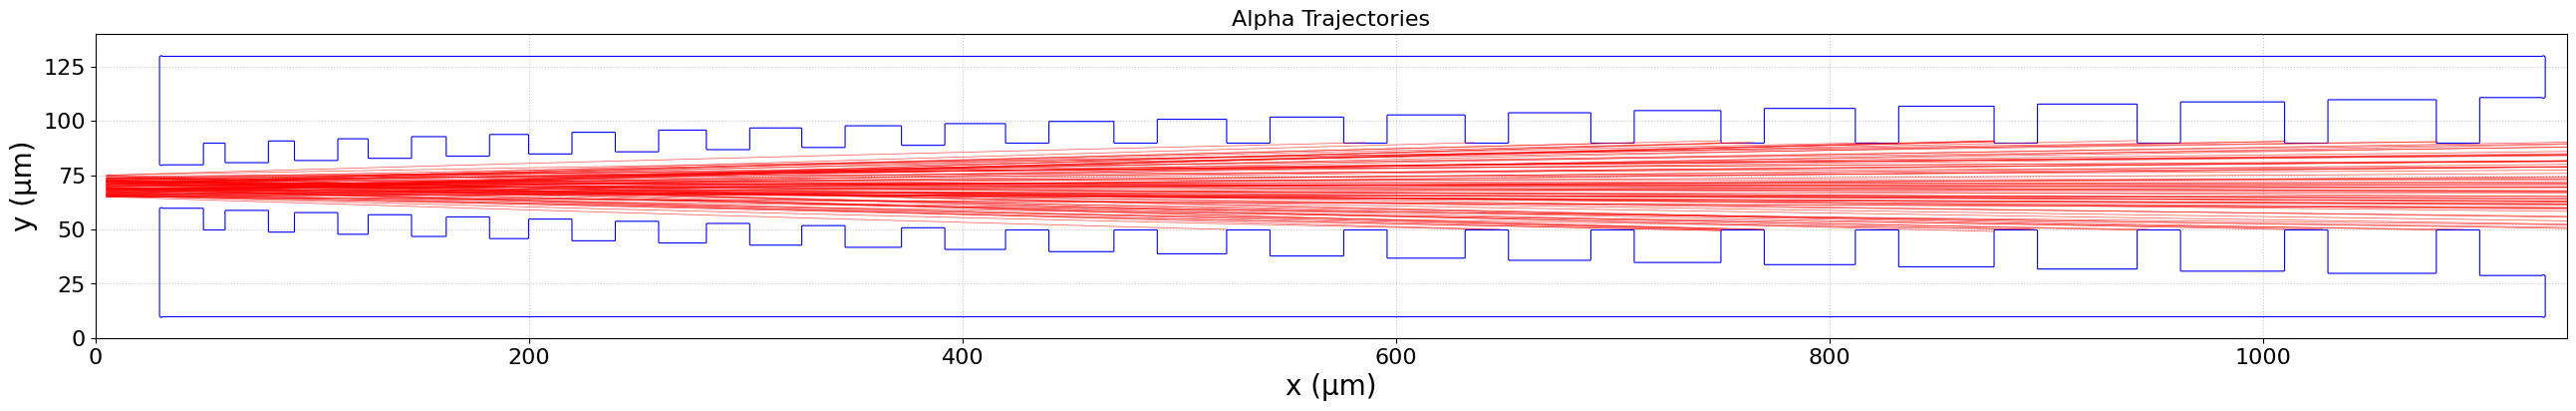

In [11]:
if df_all_trajectories is not None:
    plt.figure(figsize=(32, 28))
    ax = plt.gca()
    
    # Draw outline
    draw_detailed_outlines(ax, X_mesh, Y_mesh, eps_r, outline_threshold_silicon, 'b-')
    
    grouped_trajectories = df_all_trajectories.groupby('proton_id')
    proton_ids = list(grouped_trajectories.groups.keys())
    num_protons = len(proton_ids)
    
    # Plot a subset
    num_to_plot = min(num_protons, 100)
    convert_to_um = 1e6
    
    print(f"Plotting {num_to_plot} trajectories...")
    
    for i in range(num_to_plot):
        pid = proton_ids[i]
        df_traj = grouped_trajectories.get_group(pid)
        x_vals = df_traj['x_m'].values * convert_to_um
        y_vals = df_traj['y_m'].values * convert_to_um
        ax.plot(x_vals, y_vals, linestyle='-', linewidth=0.5, alpha=0.7, color='red')

    ax.set_title(f'Alpha Trajectories', fontsize=16)
    ax.set_xlabel('x (μm)', fontsize=20)
    ax.set_ylabel('y (μm)', fontsize=20)
    ax.tick_params(axis='both',which='major', labelsize=16)
    ax.set_aspect('equal', adjustable='box')
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.show()
else:
    print("No trajectory data available to plot.")

### Plot 7: Final Energy Histogram

In [12]:
if df_all_trajectories is not None:
    final_energies_eV = []
    
    # Determine simulation end from x_coords
    L_total_sim_m = x_coords[-1] * 1e-6
    x_success_threshold = L_total_sim_m * 0.95 # logical threshold

    grouped = df_all_trajectories.groupby('proton_id')
    
    for pid, df_traj in grouped:
        last_point = df_traj.iloc[-1]
        
        # Check if reached the end (approx)
        if last_point['x_m'] >= x_success_threshold:
            vx = last_point['vx_m_per_s']
            vy = last_point['vy_m_per_s']
            v_sq = vx**2 + vy**2
            ke_joules = 0.5 * M_PROTON_KG * v_sq
            ke_eV = ke_joules / E_CHARGE_C
            final_energies_eV.append(ke_eV)
            
    if final_energies_eV:
        plt.figure(figsize=(10, 6))
        plt.hist(final_energies_eV, bins=50, edgecolor='black', alpha=0.75, color='mediumseagreen')
        plt.xlabel("Final Kinetic Energy (eV)")
        plt.ylabel("Number of Protons")
        plt.title("Histogram of Final Kinetic Energies")
        plt.grid(True, alpha=0.7)
        
        mean_ke = np.mean(final_energies_eV)
        std_ke = np.std(final_energies_eV)
        stats = f"Mean: {mean_ke:.2f} eV\nStd: {std_ke:.2f} eV"
        plt.text(0.95, 0.95, stats, transform=plt.gca().transAxes, ha='right', va='top', 
                 bbox=dict(boxstyle='round', fc='wheat', alpha=0.5))
        plt.show()
    else:
        print("No protons reached the end.")

NameError: name 'M_PROTON_KG' is not defined

### Plot 8: Final Angle Histogram

In [ ]:
if df_all_trajectories is not None:
    final_angles_deg = []
    
    grouped = df_all_trajectories.groupby('proton_id')
    for pid, df_traj in grouped:
        last_point = df_traj.iloc[-1]
        
         # Check if reached the end (approx)
        if last_point['x_m'] >= x_success_threshold:
            vx = last_point['vx_m_per_s']
            vy = last_point['vy_m_per_s']
            angle_rad = np.arctan2(vy, vx)
            angle_deg = np.degrees(angle_rad)
            final_angles_deg.append(angle_deg)
            
    if final_angles_deg:
        plt.figure(figsize=(10, 6))
        plt.hist(final_angles_deg, bins=50, edgecolor='black', alpha=0.75, color='coral')
        plt.xlabel("Final Angle (degrees)")
        plt.ylabel("Number of Protons")
        plt.title("Histogram of Final Angles")
        plt.grid(True, alpha=0.7)
        
        mean_ang = np.mean(final_angles_deg)
        std_ang = np.std(final_angles_deg)
        stats = f"Mean: {mean_ang:.2f}°\nStd: {std_ang:.2f}°"
        plt.text(0.95, 0.95, stats, transform=plt.gca().transAxes, ha='right', va='top', 
                 bbox=dict(boxstyle='round', fc='lightyellow', alpha=0.5))
        plt.show()
    else:
        print("No protons reached the end.")

# Comparative Analysis of Geometries

This section compares the different simulated geometries found in the workspace. It gathers data from all available geometry folders to compare:
1.  **Electric Field Profile**: Comparison of $|E|$ along the center of the gap.
2.  **Particle Performance**: Comparison of final kinetic energy and transmission rates.

In [ ]:
geometry_folders = {
    "Deep Phase-Shifted Teeth": "geometria_Denti_sfasati_profondi_proton",
    "Uniform Teeth": "geometria_Denti_uguali_proton",
    "Tapered Plane": "geometria_piana_rastremata_proton",
   }

# Redefine constants locally to ensure standalone execution
M_PROTON_KG = 1.6726219e-27  # Mass of proton in kg
E_CHARGE_C = 1.60217663e-19   # Elementary charge in Coulombs
E_ELEMENTARY_C = 1.60217663e-19

# Set active particle constants
M_PARTICLE_KG = M_PROTON_KG
Q_PARTICLE_C = E_CHARGE_C

comparison_data = []

print("Starting Comparative Analysis (Protons)...")

for label, folder in geometry_folders.items():
    if not os.path.exists(folder):
        # Try to find if it exists in current dir
        if not os.path.isdir(folder):
             print(f"Skipping {label}: Folder '{folder}' not found.")
             continue
    
    print(f"Processing {label}...")
    
    # Define file paths
    ex_f = os.path.join(folder, "electric_field_x.csv")
    ey_f = os.path.join(folder, "electric_field_y.csv")
    x_f = os.path.join(folder, "x_coordinates.csv")
    y_f = os.path.join(folder, "y_coordinates.csv")
    gp_f = os.path.join(folder, "geometry_params.csv")
    traj_f = os.path.join(folder, "all_proton_trajectories.csv")
    
    # Load Data
    Ex_c = load_2d_csv(ex_f)
    Ey_c = load_2d_csv(ey_f)
    x_c = load_1d_csv(x_f)
    y_c = load_1d_csv(y_f)
    g_params = load_geometry_params_for_plot(gp_f)
    
    # Skip if essential fields are missing
    if any(v is None for v in [Ex_c, Ey_c, x_c, y_c, g_params]):
        print(f"  -> Missing field or mesh data for {label}")
        continue

    # --- 1. Calculate Center Line for Field Profile ---
    y_cnt_idx = None
    if g_params:
        # Robust logic to find the center of the vacuum gap
        y_si_base_h = g_params.get("y_si_base_height")
        y_teeth_h_val = g_params.get("initial_y_teeth_height") or g_params.get("y_teeth_height") or g_params.get("y_tooth_height") 
        y_vac_gap_thick = g_params.get("y_vacuum_gap_thick")
        pad_bottom = g_params.get("y_vacuum_padding_bottom", 0.0)
        
        y_center_abs = None
        # Logic for toothed geometries
        if y_si_base_h is not None and y_teeth_h_val is not None and y_vac_gap_thick is not None:
             y_center_abs = pad_bottom + y_si_base_h + y_teeth_h_val + (y_vac_gap_thick / 2.0)
        # Logic for flat/tapered geometries
        else:
             y_si_start = g_params.get("y_si_layer_thick_start") or g_params.get("y_left_si_thick") or g_params.get("y_si_layer_thick")
             y_si_end = g_params.get("y_si_layer_thick_end")
             
             if y_si_start is not None and y_vac_gap_thick is not None:
                 if y_si_end is not None: # Tapered, usually we take the average or start
                     y_center_abs = pad_bottom + y_si_start + (y_vac_gap_thick / 2.0)
                 else:
                    y_center_abs = pad_bottom + y_si_start + (y_vac_gap_thick / 2.0)
        
        if y_center_abs is not None:
             y_cnt_idx = (np.abs(y_c - y_center_abs)).argmin()
    
    # Extract Field Profile
    e_field_profile = None
    y_field_profile = None # New component to extract
    
    if y_cnt_idx is not None:
        Emag_c = np.sqrt(Ex_c**2 + Ey_c**2)
        e_field_profile = Emag_c[y_cnt_idx, :]
        y_field_profile = Ey_c[y_cnt_idx, :] # Extracting Ey component at the center line

    # --- 2. Calculate Particle Statistics & Profiles ---
    mean_energy = np.nan
    std_energy = np.nan
    mean_velocity = np.nan
    transmission_count = 0
    total_particles = 0
    v_vs_x = None
    v_vs_t = None
    max_exit_angle_deg = np.nan
    exit_angles = None
    
    if os.path.exists(traj_f):
        try:
            # Only read necessary columns for speed (Added time_s)
            df_t = pd.read_csv(traj_f, usecols=['proton_id', 'time_s', 'x_m', 'vx_m_per_s', 'vy_m_per_s'])
            
            # Determine success threshold (reached 95% of length)
            x_threshold = x_c[-1] * 1e-6 * 0.95
            
            # Group by particle to get final state
            last_points = df_t.groupby('proton_id').last()
            total_particles = len(last_points)
            
            success_mask = last_points['x_m'] >= x_threshold
            success_particles = last_points[success_mask]
            
            transmission_count = len(success_particles)
            
            if transmission_count > 0:
                v_sq = success_particles['vx_m_per_s']**2 + success_particles['vy_m_per_s']**2
                v_mag = np.sqrt(v_sq)
                
                # Use updated Mass. KE in Joules.
                ke_j = 0.5 * M_PARTICLE_KG * v_sq
                # Energy in eV = Energy in Joules / elementary charge
                ke_ev = ke_j / E_ELEMENTARY_C
                
                mean_energy = ke_ev.mean()
                std_energy = ke_ev.std()
                mean_velocity = v_mag.mean()
                
                # --- EXIT ANGLES CALCULATION ---
                vx_final = success_particles['vx_m_per_s']
                vy_final = success_particles['vy_m_per_s']
                angles_rad = np.arctan2(vy_final, vx_final)
                exit_angles = np.degrees(angles_rad).values
                
                # Max absolute angle
                max_exit_angle_deg = np.max(np.abs(exit_angles))

            # --- Calculate Velocity Profiles ---
            df_t['v_mag'] = np.sqrt(df_t['vx_m_per_s']**2 + df_t['vy_m_per_s']**2)
            
            # 1. Velocity vs Position (Spatial Binning)
            x_min_sim, x_max_sim = x_c[0]*1e-6, x_c[-1]*1e-6
            bins_x = np.linspace(x_min_sim, x_max_sim, 200)
            bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
            
            df_t['bin_x'] = pd.cut(df_t['x_m'], bins=bins_x, labels=bin_centers_x)
            v_vs_x = df_t.groupby('bin_x', observed=False)['v_mag'].mean()
            
            # 2. Velocity vs Time (Temporal Binning)
            t_max = df_t['time_s'].max()
            bins_t = np.linspace(0, t_max, 200)
            bin_centers_t = (bins_t[:-1] + bins_t[1:]) / 2
            
            df_t['bin_t'] = pd.cut(df_t['time_s'], bins=bins_t, labels=bin_centers_t)
            v_vs_t = df_t.groupby('bin_t', observed=False)['v_mag'].mean()
                
        except Exception as e:
            print(f"  -> Error calculating trajectories for {label}: {e}")
            
    comparison_data.append({
        'label': label,
        'x_coords': x_c,
        'e_profile': e_field_profile,
        'y_profile': y_field_profile,
        'mean_energy': mean_energy,
        'std_energy': std_energy,
        'mean_velocity': mean_velocity,
        'transmission': transmission_count,
        'total_particles': total_particles,
        'v_vs_x': v_vs_x,
        'v_vs_t': v_vs_t,
        'max_exit_angle': max_exit_angle_deg,
        'exit_angles': exit_angles
    })

print("Done collecting data.")

In [ ]:
# --- Comparative Plots ---

# 1. Electric Field Profiles (|E|)
plt.figure(figsize=(14, 7))

has_profile_data = False
for data in comparison_data:
    if data['e_profile'] is not None:
        plt.plot(data['x_coords'], data['e_profile'], label=data['label'], linewidth=2.5, alpha=0.8)
        has_profile_data = True

if has_profile_data:
    plt.title("Comparison of Electric Field Magnitude (|E|) at Channel Center", fontsize=15, fontweight='bold')
    plt.xlabel("x position (μm)", fontsize=13)
    plt.ylabel("Electric Field |E| (V/μm)", fontsize=13)
    plt.legend(fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
else:
    print("No electric field profile data available.")

# 1b. Transverse Electric Field Profiles (Ey)
plt.figure(figsize=(14, 7))

has_y_profile_data = False
for data in comparison_data:
    if data.get('y_profile') is not None:
        plt.plot(data['x_coords'], data['y_profile'], label=data['label'], linewidth=2.0, alpha=0.8)
        has_y_profile_data = True

if has_y_profile_data:
    plt.title("Comparison of Transverse Electric Field (Ey) at Channel Center", fontsize=15, fontweight='bold')
    plt.xlabel("x position (μm)", fontsize=13)
    plt.ylabel("Electric Field Ey (V/μm)", fontsize=13)
    plt.legend(fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
else:
    print("No transverse electric field profile data available.")


# 2. Energy Bar Chart
valid_energy_data = [d for d in comparison_data if not np.isnan(d['mean_energy'])]

if valid_energy_data:
    labels = [d['label'] for d in valid_energy_data]
    means = [d['mean_energy'] for d in valid_energy_data]
    stds = [d['std_energy'] for d in valid_energy_data]
    transmissions = [f"{d['transmission']}/{d['total_particles']}" for d in valid_energy_data]
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(labels, means, yerr=stds, capsize=10, color='mediumslateblue', alpha=0.85, edgecolor='black')
    
    plt.title("Comparison of Mean Final Kinetic Energy", fontsize=15, fontweight='bold')
    plt.ylabel("Kinetic Energy (eV)", fontsize=13)
    plt.xlabel("Geometry", fontsize=13)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Add text labels on bars
    for bar, trans in zip(bars, transmissions):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + (height*0.05),
                f'{height:.1f} eV',
                ha='center', va='bottom', fontweight='bold')
        # Show transmission count inside the bar
        plt.text(bar.get_x() + bar.get_width()/2., height/2,
                f"N={trans}",
                ha='center', va='center', color='white', fontweight='bold')

    plt.tight_layout()
    plt.show()
    
    # Print Summary Table
    print(f"\n{'Geometry Name':<30} | {'Mean Energy':<12} | {'Std Dev':<10} | {'Max Vel (m/s)':<15} | {'Transm.':<10}")
    print("-" * 90)
    for d in valid_energy_data:
        print(f"{d['label']:<30} | {d['mean_energy']:<8.2f} eV | {d['std_energy']:<6.2f} eV | {d['mean_velocity']:<11.2e} | {d['transmission']}/{d['total_particles']}")
else:
    print("No particle energy data available.")

# 3. Average Velocity vs Position
plt.figure(figsize=(14, 7))
has_vel_space_data = False

for data in comparison_data:
    if data.get('v_vs_x') is not None:
        series = data['v_vs_x']
        # Check if series is valid and not all NaN
        if not series.dropna().empty:
            # Convert bin centers (meters) to um
            x_um = np.array(series.index.tolist()) * 1e6
            plt.plot(x_um, series.values, label=data['label'], linewidth=2.5, alpha=0.8)
            has_vel_space_data = True

if has_vel_space_data:
    plt.title("Comparison of Average Particle Velocity vs Position", fontsize=15, fontweight='bold')
    plt.xlabel("x position (μm)", fontsize=13)
    plt.ylabel("Average Velocity (m/s)", fontsize=13)
    plt.legend(fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
else:
    print("No velocity vs position data available.")

# 4. Average Velocity vs Time
plt.figure(figsize=(14, 7))
has_vel_time_data = False

for data in comparison_data:
    if data.get('v_vs_t') is not None:
        series = data['v_vs_t']
        if not series.dropna().empty:
            # Convert bin centers (seconds) to ns
            t_ns = np.array(series.index.tolist()) * 1e9
            plt.plot(t_ns, series.values, label=data['label'], linewidth=2.5, alpha=0.8)
            has_vel_time_data = True

if has_vel_time_data:
    plt.title("Comparison of Average Particle Velocity vs Time", fontsize=15, fontweight='bold')
    plt.xlabel("Time (ns)", fontsize=13)
    plt.ylabel("Average Velocity (m/s)", fontsize=13)
    plt.legend(fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
else:
    print("No velocity vs time data available.")

# 5. Max Exit Angle Comparison (Scatter Plot)
valid_angle_data = [d for d in comparison_data if d.get('max_exit_angle') is not None and not np.isnan(d['max_exit_angle'])]

if valid_angle_data:
    labels = [d['label'] for d in valid_angle_data]
    max_angles = [d['max_exit_angle'] for d in valid_angle_data]
    
    plt.figure(figsize=(10, 6))
    
    # Use index for x-axis
    x_pos = np.arange(len(labels))
    
    # Scatter plot with large markers
    # Error bars are not strictly applicable to a single 'Max' value from one distribution, 
    # but we use errorbar to allow for future addition or to match the 'eventual error' request style (yerr=None).
    plt.errorbar(x_pos, max_angles, yerr=None, fmt='o', markersize=12, 
                 color='coral', markeredgecolor='black', capsize=5, label='Max |Angle|')
    
    plt.title("Comparison of Maximum Absolute Exit Angle", fontsize=15, fontweight='bold')
    plt.ylabel("Max |Angle| (degrees)", fontsize=13)
    plt.xlabel("Geometry", fontsize=13)
    plt.xticks(x_pos, labels)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Extend Y limit slightly for text
    y_min, y_max = plt.ylim()
    plt.ylim(0, y_max * 1.1)
    
    # Add values
    for i, val in enumerate(max_angles):
        plt.text(i, val + (val*0.02), f'{val:.2f}°', 
                 ha='center', va='bottom', fontweight='bold', fontsize=11)

    plt.tight_layout()
    plt.show()

# 6. Exit Angle Distribution (Boxplot)
angle_data_list = []
angle_labels = []

for d in comparison_data:
    if d.get('exit_angles') is not None and len(d['exit_angles']) > 0:
        angle_data_list.append(d['exit_angles'])
        angle_labels.append(d['label'])

if angle_data_list:
    plt.figure(figsize=(12, 6))
    plt.boxplot(angle_data_list, labels=angle_labels, patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='blue'),
                medianprops=dict(color='red', linewidth=2))
    
    plt.title("Distribution of Exit Angles", fontsize=15, fontweight='bold')
    plt.ylabel("Exit Angle (degrees)", fontsize=13)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Print stats on plot
    for i, angles in enumerate(angle_data_list):
        mean_val = np.mean(angles)
        std_val = np.std(angles)
        max_val = np.max(angles)
        min_val = np.min(angles)
        
        # Determine position (above or below box)
        y_pos = np.max(angles)
        
        stats_text = (f"Mean: {mean_val:.2f}°\n"
                      f"Std: {std_val:.2f}°\n"
                      f"Max: {max_val:.2f}°\n"
                      f"Min: {min_val:.2f}°")
        
        # Just printing to console for detail, plot might get crowded
        print(f"\nStats for {angle_labels[i]}:")
        print(stats_text)

    plt.tight_layout()
    plt.show()

## Geometry Visualization and Dimensions

This section visualizes the material structure (permittivity map) for each geometry and displays the key geometric parameters extracted from the simulation configuration.

In [ ]:
# Visualization of Geometries and Dimensions
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

# --- USER COLOR SETTINGS ---
# Define the colors you want for each material here:
COLOR_VACUUM = '#FFFFFF'      # White
COLOR_SILICON = 'blue'        # Blue for Silicon
COLOR_ALUMINUM = 'red'        # Red for Aluminum (Metal)

geometry_folders_list = [
    ("Deep Phase-Shifted Teeth", "geometria_Denti_sfasati_profondi"),
    ("Uniform Teeth", "geometria_Denti_uguali"),
    ("Tapered Plane", "geometria_piana_rastremata")
]

# Initialize figure
fig = plt.figure(figsize=(14, 4 * len(geometry_folders_list)))

print("Generating improved geometry visualization with custom colors...")

for i, (label, folder) in enumerate(geometry_folders_list):
    ax = plt.subplot(len(geometry_folders_list), 1, i+1)
    
    # File paths
    eps_file = os.path.join(folder, "permittivity.csv")
    x_file = os.path.join(folder, "x_coordinates.csv")
    y_file = os.path.join(folder, "y_coordinates.csv")
    geom_file = os.path.join(folder, "geometry_params.csv")
    
    # Check existence
    if not os.path.exists(eps_file):
        ax.text(0.5, 0.5, f"Data not found for: {label}\n({folder})", ha='center', fontsize=12)
        ax.set_title(label)
        ax.axis('off')
        continue

    # Load data
    eps_data = load_2d_csv(eps_file)
    x_data = load_1d_csv(x_file)
    y_data = load_1d_csv(y_file)
    params = load_geometry_params_for_plot(geom_file)
    
    # Plotting
    if eps_data is not None and x_data is not None and y_data is not None:
        # Determine Extent for imshow
        if len(x_data) > 1 and len(y_data) > 1:
            dx = (x_data[-1] - x_data[0]) / (len(x_data) - 1)
            dy = (y_data[-1] - y_data[0]) / (len(y_data) - 1)
            extent = [x_data[0] - dx/2, x_data[-1] + dx/2, y_data[0] - dy/2, y_data[-1] + dy/2]
        else:
            extent = [x_data[0], x_data[-1], y_data[0], y_data[-1]]
        
        # --- Custom Material Mapping ---
        # Map permittivity values to integer indices: 0 (Vac), 1 (Si), 2 (Al)
        eps_map_val = np.zeros_like(eps_data, dtype=int)
        
        # Thresholds
        mask_metal = eps_data > 20.0
        mask_silicon = (eps_data > 2.0) & (eps_data <= 20.0)
        
        eps_map_val[mask_silicon] = 1
        eps_map_val[mask_metal] = 2
        
        # Define Color Map
        custom_colors = [COLOR_VACUUM, COLOR_SILICON, COLOR_ALUMINUM]
        cmap_custom = mcolors.ListedColormap(custom_colors)
        
        # Use imshow
        im = ax.imshow(eps_map_val, extent=extent, origin='lower', 
                       cmap=cmap_custom, vmin=0, vmax=2, aspect='equal')

        # Prepare text for dimensions
        dim_text = ""
        if params:
            keys_to_display = [
                ('y_vacuum_gap_thick', 'Gap'), 
                ('tooth_width', 'Tooth W'),
                ('tooth_period', 'Period'),
                ('y_teeth_height', 'Teeth H'), 
                ('initial_y_teeth_height', 'Teeth H'),
                ('y_si_layer_thick_start', 'Si Thick')
            ]
            
            found_dims = []
            for key, nice_name in keys_to_display:
                val = params.get(key)
                if val is not None:
                    if not any(nice_name in s for s in found_dims):
                        if isinstance(val, (int, float)):
                            found_dims.append(f"{nice_name}={val:.1f}")
                        else:
                            found_dims.append(f"{nice_name}={val}")
            
            dim_text = "  |  ".join(found_dims)
        
        title_str = f"{label}"
        if dim_text:
            title_str += f"\n[{dim_text}]"
        
        ax.set_title(title_str, fontsize=13, fontweight='bold', pad=10)
        ax.set_xlabel("x (μm)")
        ax.set_ylabel("y (μm)")
        
        # --- Increase Axis Density (Infittire gli assi) ---
        ax.xaxis.set_major_locator(ticker.MultipleLocator(35.0)) # Ticks every 5 um on X
        ax.yaxis.set_major_locator(ticker.MultipleLocator(35.0)) # Ticks every 5 um on Y
        ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.5, color='gray') # Add light grid

        # Add thin boundaries for clarity
        X, Y = np.meshgrid(x_data, y_data)
        ax.contour(X, Y, eps_data, levels=[5, 20], colors='black', linewidths=0.5, alpha=0.3)

# --- Create Unified Legend ---
legend_patches = [
    mpatches.Patch(facecolor=COLOR_VACUUM, edgecolor='gray', label='Vacuum'),
    mpatches.Patch(facecolor=COLOR_SILICON, edgecolor='gray', label='Silicon'),
    mpatches.Patch(facecolor=COLOR_ALUMINUM, edgecolor='gray', label='Aluminum')
]

# Place legend at the top of the figure
legend = fig.legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0.5, 0.95), 
                    ncol=3, fontsize=12, frameon=True, facecolor='white', edgecolor='lightgray')

plt.tight_layout()
plt.subplots_adjust(top=0.93) # Adjust top margin to make room for legend
plt.show()